In [232]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

!pip install fanalysis
from fanalysis.mca import MCA

from sklearn.metrics import confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [233]:
# option d'affichage des résultats
pd.set_option("display.max_row",130)
pd.set_option("display.max_columns",100)

In [234]:
# les noms des variables

colonnes =(["IDENT", "TypeHabi", "GeoFaz_Scl", "GeoFaz_cl", "ImmoFaz_Scl", "ImmoFaz_cl", "Anciennete",
            "Logement_prix_m2", "Mediane_RFR", "Sexe", "Prenom_Phase_scl_H", "Prenom_Phase_scl_F",
            "Prenom_Phase_cl_H", "Prenom_Phase_cl_F", "Age_H", "Age_F", "Affinite_1", "Affinite_2",
            "Prenom_effectif", "Potentiel_prenom", "Onoma-Phase_Scl", "Onoma-Phase_CL", "Top_mon"])

In [235]:

colonnes_montant = ["DEDUPLI", "IDENT", "SommeDeMONTANT_NUM", "Flag_Top_Montant", "NovosScore_Vingtile"]
colonnes_montant = colonnes_montant[:-1]

data_montant_orig = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_AAPOT21/DONS_AA_N_TODAY_1ers gestes_REF_MD.txt", sep=";", header = 0, low_memory=False, dtype=str) #, dtype='Int64')
data_montant_orig =data_montant_orig.iloc[:,1:]  

data_montant_orig.iloc[:,2]=data_montant_orig.iloc[:,2].str.replace(",",".")

data_montant_orig.columns =colonnes_montant
data_montant_orig["SommeDeMONTANT_NUM"]=data_montant_orig["SommeDeMONTANT_NUM"].astype(float)


In [236]:
# importation du fichier (changer le chemin d'accès)
''' Faites attention au type de fichier, au délimiteur des valeurs (ça doit être unique et non multiple),
au header et à la lecture des types d'objets (low_memory) '''

data_orig = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_AAPOT21/sep_AAPOT21.txt", delim_whitespace="\t", header = None, names=colonnes, low_memory=False, dtype=str )#, dtype='Int64')


In [237]:
''' copie superficielle (peu profonde) du dataset original pour ne pas modifier les valeurs
d'origine par erreur plus tard 
'''
data = data_orig.copy()
data.shape

(152510, 23)

In [238]:
# visualisation des premiers lignes
data.head()


,IDENT,TypeHabi,GeoFaz_Scl,GeoFaz_cl,ImmoFaz_Scl,ImmoFaz_cl,Anciennete,Logement_prix_m2,Mediane_RFR,Sexe,Prenom_Phase_scl_H,Prenom_Phase_scl_F,Prenom_Phase_cl_H,Prenom_Phase_cl_F,Age_H,Age_F,Affinite_1,Affinite_2,Prenom_effectif,Potentiel_prenom,Onoma-Phase_Scl,Onoma-Phase_CL,Top_mon
0,0010000067,01,72,07,83,08,06,17,18,03,44,81,04,08,06,12,02,03,04,12,31,03,1
1,0010000070,01,72,07,84,08,05,18,20,01,33,44,03,04,08,08,05,09,05,20,36,03,2
2,0010000090,03,64,06,75,07,05,13,08,01,71,67,07,06,12,11,10,08,04,02,22,02,2
3,0010000124,03,43,04,82,08,01,15,17,03,51,81,05,08,10,12,10,14,05,15,61,06,2
4,0010000147,02,25,02,32,03,07,07,15,05,71,81,07,08,12,12,21,21,06,21,61,06,1


In [239]:
#nombre de modalités de chaque variables (dans un dataframe)
def nombre_mod(data2):
    #création d'un dataframe vide
    dff= pd.DataFrame(columns=["VARIABLE","NOMBRE_MOD", "NOMBRE_MOD_SANS_NA"])
    for i in range(data2.shape[1]): # sans compter les valeurs manquantes
        taille =len(data2.iloc[:,i].value_counts(dropna=False))
        taille_1 = len(data2.iloc[:,i].value_counts(dropna=True) )
        dff=dff.append({"VARIABLE": colonnes[i],"NOMBRE_MOD":taille, "NOMBRE_MOD_SANS_NA":taille_1 }, ignore_index=True)
    return dff

# sélection des corrélations les plus importantes
def variables_corr(tableau_corr, seuil):
    colonnes = tableau_corr.columns
    val_temp = 0 
    variables_corr_pos=[] ; variables_corr_pos_val=[]
    variables_corr_neg=[] ; variables_corr_neg_val=[]
    for i in range(tableau_corr.shape[0]):  
        for j in range(tableau_corr.shape[0]):
            if i<j: #i!=j:
                if (tableau_corr.iloc[i,j] > seuil):
                    variables_corr_pos.append(colonnes[j])
                    variables_corr_pos_val.append(round( tableau_corr.iloc[i,j], 2))
                    val_temp += 1

                if (tableau_corr.iloc[i,j] <-seuil):
                    variables_corr_neg.append(colonnes[j])
                    variables_corr_neg_val.append(round( tableau_corr.iloc[i,j], 2))
                    val_temp += 1

        if (len(variables_corr_pos) > 0) | (len(variables_corr_neg) >0) :
            print("variable : ", colonnes[i])
            if len(variables_corr_pos) > 0:    
                print("corr pos", variables_corr_pos)
                print("corr pos", variables_corr_pos_val)
                val_temp += 1

            if len(variables_corr_neg) >0:  
                print("corr neg", variables_corr_neg)
                print("corr neg", variables_corr_neg_val)
                val_temp += 1
            print("")
        variables_corr_pos = variables_corr_pos*0
        variables_corr_neg = variables_corr_pos*0

        variables_corr_pos_val = variables_corr_pos_val*0
        variables_corr_neg_val = variables_corr_pos_val*0
    if val_temp == 0:
        print("IL N'Y A PAS DE CORRELATION ENTRE LES VARIABLES PAR RAPPORT AU SEUIL PRIS")
        

def evaluation(model, X_train, y_train, X_test, y_test, scoring, plot):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("test set : ")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred)) 
    print("train set : ")
    print(confusion_matrix(y_train, model.predict(X_train)))  
    print(classification_report(y_train, model.predict(X_train) ))

    if plot == True:
        N, train_score, val_score = learning_curve(model, X_train, y_train, shuffle=True, cv = 4, scoring = scoring, train_sizes = np.linspace(0.1, 1, 6) )

        plt.figure(figsize = (10,6))
        plt.plot(N, train_score.mean(axis=1), label ="train_score")
        plt.plot(N, val_score.mean(axis=1), label ="cross_validation_score")
        plt.legend()
    else :
        print("GRAPHIQUE NON DEMANDE")

# Comme il n'y a pas de valeurs manquantes (à la place il y a un nombre), le seul traitement qu'on fait c'est tranformer
# le type de variable (les variables continues deviennent qualitatives)
def data_processing(df):
    """ 
    for i in range(0,len(df.columns)):    
        df[df.columns[i]].fillna(100.0, inplace=True) #On remplace les données manquantes par 100
    for i in range(0,len(df.columns)):
        print(df[df.columns[i]].value_counts(dropna=False))    
    """
    
   #Transformation de toutes les variables en facteurs         
    for i in range(0,len(df.columns)):
        df[df.columns[i]] = df[df.columns[i]].astype('category')
    return df.to_numpy() #.as_matrix()


def vingtiles(model, data_orig, affichage, save, path): # data_orig est une variables locale (peut être différente au df d'origine)
    # position de la dernière variable explicative dans le dataset
    nb_var = data_orig.shape[1]-1

    # predict sur tous les individus (avec et sans classe Top_mon)
    tous_probas = model.predict_proba(data_orig.iloc[:,1:nb_var])
    df_tous = pd.DataFrame({'IDENT': data_orig.iloc[:,0] , 'PROBA': tous_probas[:,0] })
    #df_tous
    
    # valeurs ordonnées pour diviser après
    df_tous=df_tous.sort_values(by='PROBA', ascending=True)
    #df_tous
    print(df_tous)
    
    #vérification
    print(df_tous['PROBA'].value_counts())

    # vingtiles
    df_temp =pd.DataFrame( pd.qcut(df_tous['PROBA'],q= 20)  )
    #print(df_temp)

    # ajout par index (IMPORTANTE)
    df_tous["TRANCHES"]=pd.DataFrame(df_temp.iloc[:,0].to_numpy(),index= df_temp.index)
    #print(df_tous)

    # création de la dernière colonne CLASSE et son remplissage
    index_20_ord = pd.DataFrame(np.unique(df_tous["TRANCHES"])) 
    df_tous["CLASSE"]=df_tous["TRANCHES"].copy()
    ind_val=1
    for kk in range(20):
        df_tous["CLASSE"][df_tous["CLASSE"]== index_20_ord.iloc[kk,0] ] = str(ind_val) 
        ind_val+=1
    print(df_tous)    
    
    # pour la colonne Top_mon : changement de type de variable et remplissage des valeurs (s'il le faut)
    data_temp_t = data_orig.copy()
    data_temp_t["Top_mon"] =  data_temp_t["Top_mon"].replace(1.0,'1')
    data_temp_t["Top_mon"] =  data_temp_t["Top_mon"].replace(2.0,'2')
    data_all_complet_class = data_temp_t #data_temp_t.fillna('2')
    #data_all_complet_class

    # jointure
    ident_class_tous = data_all_complet_class[["IDENT","Top_mon"]]
    tableau_resultats = pd.merge(df_tous,ident_class_tous)
    #tableau_resultats

    # tranches finales
    tab_cross_temp = pd.crosstab(tableau_resultats["TRANCHES"],tableau_resultats["Top_mon"])
    #print(tab_cross_temp); print("-----------------------")

    # création d'une colonne TOTAL
    tab_cross_temp["TOTAL"]=tab_cross_temp["1"]+tab_cross_temp["2"]
    
    # affichage
    if affichage ==True:        
        print(tab_cross_temp)

    # création du tableau final en éliminant la colonne 2
    #tab_pour_excel = tab_cross_temp.drop(["2"], axis=1)

    # si on ne veut pas éliminer la colonne 2
    tab_pour_excel =  tab_cross_temp
    
    # enregistrement sous Excel
    if save == True:
        tab_pour_excel.to_excel(path)

    return  df_tous


def tableau_5_montant(df_tous, data_montant_orig, affichage, save, path):
    # tableau avec les deux variables qui nous intéressent
    ident_et_montant = data_montant_orig[["IDENT","SommeDeMONTANT_NUM"]]

    # jointure
    tableau_resultats_et_montant = pd.merge(df_tous,ident_et_montant)
    #print(tableau_resultats_et_montant) 

    # on élimine toutes les sommes supérieur à 5000 €
    tableau_resultats_et_montant = tableau_resultats_et_montant[tableau_resultats_et_montant["SommeDeMONTANT_NUM"] <= 5000]
    print(tableau_resultats_et_montant) 
    #print(tableau_resultats_et_montant["TRANCHES"].value_counts())
    #print(pd.DataFrame(np.unique(tableau_resultats_et_montant["TRANCHES"])))

    # index
    index_temp = pd.DataFrame(np.unique(tableau_resultats_et_montant["TRANCHES"])) 

    # création du tableau qui contiendra les résultats finaux
    tableau_resultats_finaux = pd.DataFrame(columns=["TRANCHES","Moyen_Somme","TOTAL"],index=range(20))
    tableau_resultats_finaux["TRANCHES"] = index_temp

    # remplissage du tableau final
    for k in range(20):
        tableau_resultats_finaux.iloc[k,1] = tableau_resultats_et_montant[tableau_resultats_et_montant["TRANCHES"]==index_temp.iloc[k,0]]["SommeDeMONTANT_NUM"].mean()
        tableau_resultats_finaux.iloc[k,2] = (tableau_resultats_et_montant["TRANCHES"]==index_temp.iloc[k,0]).sum()
    
    # affichage
    if affichage:        
        print(tableau_resultats_finaux)
    
    # enregistrement sous Excel
    if save:
        tableau_resultats_finaux.to_excel(path)


def vingtiles_ind_sans_target(model, data_orig, affichage, save, path):
    # position de la dernière variable explicative dans le dataset
    nb_var = data_orig.shape[1]-1

    # predict sur tous les individus (avec et sans classe IFI+)
    tous_probas = model.predict_proba(data_orig.iloc[:,1:nb_var])
    df_tous = pd.DataFrame({'IDENT': data_orig.iloc[:,0] , 'PROBA': tous_probas[:,0] })
    #df_tous
    
    # valeurs ordonnées pour diviser après
    df_tous=df_tous.sort_values(by='PROBA', ascending=True)
    #df_tous
    print(df_tous)
    
    #vérification
    print(df_tous['PROBA'].value_counts())

    # quarantiles
    df_temp =pd.DataFrame( pd.qcut(df_tous['PROBA'],q= 20)  )
    print(df_temp)

    # ajout par index (IMPORTANTE)
    df_tous["TRANCHES"]=pd.DataFrame(df_temp.iloc[:,0].to_numpy(),index= df_temp.index)
    print(df_tous)
    print(df_tous["TRANCHES"].value_counts(ascending = True))

    # GERE L'ORDRE
    patra = np.unique(df_tous.iloc[:,2], return_counts=True)
    df_tranches_sans_target = pd.DataFrame([patra[0],patra[1]]).T
    df_tranches_sans_target.columns=["TRANCHES","COUNTS"]

    # affichage
    if affichage ==True:        
        print(df_tranches_sans_target)
    
    # enregistrement sous Excel
    if save == True:
        df_tranches_sans_target.to_excel(path)
    

# élimination des variables trop corrélées (choix manuel)
def elimination_val_corr(data):
    data = data.drop(columns=[""])
    return data
          
 

In [240]:
############################################################### AJOUTER OU EFFACER (data =) #######################################
# on élimine les variables corr
data=data.drop(["GeoFaz_cl", "ImmoFaz_Scl", "ImmoFaz_cl", "Prenom_Phase_cl_H", "Prenom_Phase_cl_F", "Onoma-Phase_Scl", "Onoma-Phase_CL"],axis=1)


In [241]:
num_var_max = data.shape[1] - 1
num_var_max

15

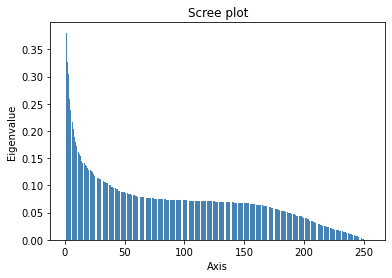

None


In [242]:
#importation de la librairie
from fanalysis.mca import MCA

#instanciation
acm = MCA(var_labels=data.columns[1:num_var_max])

# apprentissage
dim_temporaire = data_orig[(data_orig.isnull()).sum(axis=1) == 0].shape[0]
acm.fit(data.iloc[:dim_temporaire,1:num_var_max].values) # (ATTENTION : il faut prendre la taille du dataset AAPOT21 et non AATOT21)
#valeurs propres - graphique
print(acm.plot_eigenvalues())

In [243]:
# fonction qui va diviser et calculer les coordonnées des individus 
def transform_to_coord(data):
    coord_part = 0
    coord = acm.transform(data.iloc[0:30000,1:num_var_max].values)
    k=30000
    nb_part = round(data.shape[0]/k)
    for i in range(1, nb_part):
        coord_part=acm.transform(data.iloc[i*k:(i+1)*k,1:num_var_max].values)
        coord=np.concatenate((coord, coord_part))

    coord_part = acm.transform(data.iloc[nb_part*k: ,1:num_var_max].values )
    coord=np.concatenate((coord, coord_part))
    return coord

In [244]:
#instanciation
acm = MCA(var_labels = data.columns[1:num_var_max], n_components=15)  # paramètres index manquante (gérer après)
#apprentissage 
"ne pas utiliser fit_tranform car le datset est trop grand "
dim_temporaire = data_orig[(data_orig.isnull()).sum(axis=1) == 0].shape[0]
acm.fit(data.iloc[:dim_temporaire,1:num_var_max].values) # (ATTENTION : il faut prendre la taille du dataset AAPOT21 et non AATOT21)
# tranformation du dataset
coord = transform_to_coord(data)


In [245]:
# dimension
coord.shape

(152510, 55)

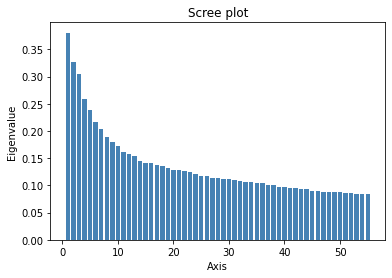

None


In [246]:
#valeurs propres - graphique
print(acm.plot_eigenvalues())


In [247]:
#coordonnées des colonnes
print(acm.col_topandas())

                     col_coord_dim1  col_coord_dim2  col_coord_dim3  \
TypeHabi_01               -0.373136        0.188474       -0.218330   
TypeHabi_02                0.208977       -0.099083        0.119195   
TypeHabi_03               -0.095624        0.003844       -0.029392   
TypeHabi_04               -0.778125        1.468221       -1.385161   
GeoFaz_Scl_11              0.216295        0.022946        0.051189   
...                             ...             ...             ...   
Potentiel_prenom_17        1.456212        0.045287       -0.125030   
Potentiel_prenom_18        1.236067        0.036591       -0.138493   
Potentiel_prenom_19        1.018261        0.018215       -0.310573   
Potentiel_prenom_20        0.998250       -0.009927       -0.337480   
Potentiel_prenom_21       -0.463648        4.468289        1.290694   

                     col_coord_dim4  col_coord_dim5  col_coord_dim6  \
TypeHabi_01                0.103883       -0.014954        0.200419   
TypeH

In [248]:
#nombre var. actives
p = data.shape[1]-1
print(p)
#calcul des fonctions de projection
fproj = np.zeros(acm.col_coord_.shape)
#pour chaque colonne
for j in range(fproj.shape[1]):
 fproj[:,j] = acm.col_coord_[:,j]/(p*np.sqrt(acm.eig_[0,j]))
#affichage fonction
print(fproj)
#affichage plus avenant des deux premiers facteurs
print(pd.DataFrame(fproj,index=acm.col_labels_))


15
[[-4.03194814e-02  2.19774844e-02 -2.63664229e-02 ...  2.06432664e-03
   1.11771512e-02 -1.79905235e-02]
 [ 2.25811525e-02 -1.15538013e-02  1.43945006e-02 ...  2.83668367e-03
   4.23866664e-03 -8.41091479e-03]
 [-1.03327092e-02  4.48272079e-04 -3.54954701e-03 ... -2.03212088e-02
  -4.40830161e-02  8.20577606e-02]
 ...
 [ 1.10028958e-01  2.12395484e-03 -3.75060491e-02 ...  4.11000502e-03
  -3.62462305e-02  1.11160281e-01]
 [ 1.07866648e-01 -1.15751133e-03 -4.07555074e-02 ... -5.26706397e-02
  -5.57811856e-03 -1.72642733e-02]
 [-5.00998466e-02  5.21034807e-01  1.55869622e-01 ...  2.54670179e-03
  -6.85458678e-03  7.43904069e-04]]
                           0         1         2         3         4   \
TypeHabi_01         -0.040319  0.021977 -0.026366  0.013628 -0.002041   
TypeHabi_02          0.022581 -0.011554  0.014395 -0.006953  0.001297   
TypeHabi_03         -0.010333  0.000448 -0.003550  0.002927 -0.002247   
TypeHabi_04         -0.084081  0.171205 -0.167278 -0.176558  0.072989

In [249]:
# affichafe des 10 premières lignes
print(coord[:2,:])


[[ 0.06093485  0.10086818 -0.73007285 -0.44417444 -0.08987511  0.03850469
  -0.30380395  1.10215093  0.81301489 -0.49341628  0.16389212  0.45675505
  -0.12541652 -0.41596831  0.35720754 -0.11940425 -0.30648017  0.12737597
   0.37534687  0.03156098 -0.5161587   0.17105054  0.01781923 -0.06195069
  -0.49585682  0.6037199   0.41706127 -0.13682246  0.68998008  0.44156247
  -0.09501994  0.07824083 -0.39445087  0.37558238 -0.18504068  0.46344109
  -0.92951815 -1.19383291 -0.6199042  -1.05825348  0.84145438  0.10246373
   0.20201483 -0.69938497  0.6755233  -0.07110608 -0.11499954 -0.73181506
  -0.50746479  1.36949172 -0.23417539 -0.91151946 -0.26367653  0.04474027
   0.71436347]
 [-0.05236679 -0.19415547 -0.01395386 -0.51651808 -0.37870646  0.28021493
  -1.14921744  0.20819817 -0.95821915  0.28842749 -0.23179103 -0.87333204
   0.69050649 -0.02425942 -0.03726352 -0.5350517   0.48726354  0.41106854
  -0.23281814  0.026134    0.01983652  0.29965295  0.1056637   0.08279762
   0.36869744  0.111480

In [250]:
#print(data_sans_nan.shape)
#print(coord_sans_nan.shape)
#print(data_sans_nan.iloc[:,0])
#dfff.isnull().sum(axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152510 entries, 0 to 152509
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   IDENT               152510 non-null  object
 1   TypeHabi            152510 non-null  object
 2   GeoFaz_Scl          152510 non-null  object
 3   Anciennete          152510 non-null  object
 4   Logement_prix_m2    152510 non-null  object
 5   Mediane_RFR         152510 non-null  object
 6   Sexe                152510 non-null  object
 7   Prenom_Phase_scl_H  152510 non-null  object
 8   Prenom_Phase_scl_F  152510 non-null  object
 9   Age_H               152510 non-null  object
 10  Age_F               152510 non-null  object
 11  Affinite_1          152510 non-null  object
 12  Affinite_2          152510 non-null  object
 13  Prenom_effectif     152510 non-null  object
 14  Potentiel_prenom    152510 non-null  object
 15  Top_mon             152510 non-null  object
dtypes:

In [251]:
## ATTENTION
# élimination des individus n'ayant pas de valeur pour la variable Top_mon
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]
coord_sans_nan = coord[(data.isnull()).sum(axis=1) == 0] # coordonnées

#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int) # essayer avec int64

# création
def creation_df_temp(data_sans_nan, coord_sans_nan):
    dfff = pd.DataFrame()
    dfff["IDENT"] = data_sans_nan.iloc[:,0]
    for i in range(coord_sans_nan.shape[1] ): #avant 10
        dfff[str(i)]=coord_sans_nan[:,i]
    dfff["Top_mon"] = data_sans_nan.iloc[:,data_sans_nan.shape[1]-1].astype(int)
    return dfff
# stockage
data_coord_nan = creation_df_temp(data_sans_nan, coord_sans_nan)
data_coord_nan.info()
#data_coord_nan = dfff 

# maintien des individus  n'ayant pas de valeur pour la variable Top_mon

data_avec_nan = data
coord_avec_nan = coord # coordonnées
def creation_df_temp_2(data_sans_nan, coord_sans_nan):
    dfff = pd.DataFrame()
    dfff["IDENT"] = data_sans_nan.iloc[:,0]
    for i in range(coord_sans_nan.shape[1]): # avant 10
        dfff[str(i)]=coord_sans_nan[:,i]

    dfff["Top_mon"] = data_sans_nan.iloc[:,data_sans_nan.shape[1]-1] #.astype(int)

    dfff["Top_mon"] = dfff["Top_mon"].replace(1.0, '1')
    dfff["Top_mon"] = dfff["Top_mon"].replace(2.0,'2')
    #for j in range(data_sans_nan.shape[1]):
    #    if dfff.iloc[j,10+1] == 2.0:
    #        dfff.iloc[j,10+1] = 2
    #    if dfff.iloc[j, 10+1] ==1.0:
    #        dfff.iloc[j,10+1] =1

    return dfff
data_coord_avec_nan = creation_df_temp_2(data_avec_nan, coord_avec_nan)
data_coord_avec_nan.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 152510 entries, 0 to 152509
Data columns (total 57 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   IDENT    152510 non-null  object 
 1   0        152510 non-null  float64
 2   1        152510 non-null  float64
 3   2        152510 non-null  float64
 4   3        152510 non-null  float64
 5   4        152510 non-null  float64
 6   5        152510 non-null  float64
 7   6        152510 non-null  float64
 8   7        152510 non-null  float64
 9   8        152510 non-null  float64
 10  9        152510 non-null  float64
 11  10       152510 non-null  float64
 12  11       152510 non-null  float64
 13  12       152510 non-null  float64
 14  13       152510 non-null  float64
 15  14       152510 non-null  float64
 16  15       152510 non-null  float64
 17  16       152510 non-null  float64
 18  17       152510 non-null  float64
 19  18       152510 non-null  float64
 20  19       152510 non-null  

In [252]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV

import imblearn
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE


In [253]:
#data_coord_nan.shape
#train_X_s.shape

In [254]:
#data_non_corr = elimination_val_corr(data)
#nb_var = data_non_corr.shape[1] - 1
nb_var = data_coord_nan.shape[1] - 1

train_set, test_set = train_test_split(data_coord_nan, test_size = 0.2, random_state=0) # , stratify =data_coord_nan["IFI+"] )

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])

# comme les résulats sont en overfitting :
# Résultat du traitement sur le train set (under-sampling et over-sampling)
#abc_test = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/sans_val_corr_spad_under_over_sampling.txt", delim_whitespace="\t", header = None, low_memory=False, dtype="Int64" ) #, dtype='Int64')
#abc_np = abc_test.to_numpy(dtype="Int64")

#X_resampled = abc_np[:,:-1]
#y_resampled = abc_np[:, abc_np.shape[1] -1 ]


In [255]:

# dimension du train set
print("Sans aucun traitement sur le train set : " , np.unique(train_Y_s, return_counts=True))

# diminution des données
t2 = TomekLinks(random_state=0)
X_resampled, y_resampled = t2.fit_resample(train_X_s[:,:nb_var] , train_Y_s )
print("Après under-sampling : ", np.unique(y_resampled, return_counts=True ))

# augmentation des données
tl = SMOTE(random_state=0)
X_resampled, y_resampled = tl.fit_resample(X_resampled, y_resampled )
print("Après over-smapling : " , np.unique(y_resampled, return_counts=True ))

'''
# enregistrement du nouveau train set car le traitement du under-sampling prendre du temps 
pd.DataFrame(np.concatenate((X_resampled, y_resampled.reshape((y_resampled.shape[0],1)) ),
                            axis=1)).to_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/val_all_spad_under_over_sampling.txt",
                                            sep=" ", index =False , header = False )
'''

Sans aucun traitement sur le train set :  (array([1, 2]), array([24334, 97674]))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Après under-sampling :  (array([1, 2]), array([24334, 89641]))
Après over-smapling :  (array([1, 2]), array([89641, 89641]))


'\n# enregistrement du nouveau train set car le traitement du under-sampling prendre du temps \npd.DataFrame(np.concatenate((X_resampled, y_resampled.reshape((y_resampled.shape[0],1)) ),\n                            axis=1)).to_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/val_all_spad_under_over_sampling.txt",\n                                            sep=" ", index =False , header = False )\n'

In [256]:
model_LinearDiscriminantAnalysis = LinearDiscriminantAnalysis()
param = {"solver" : ["svd","lsqr", "eigen"], "tol" : [0.00001,0.0001,0.001,0.01]}

grid_LinearDiscriminantAnalysis = GridSearchCV(model_LinearDiscriminantAnalysis, param_grid= param, cv = 4, scoring = "f1")
resultat_grid_LinearDiscriminantAnalysis = grid_LinearDiscriminantAnalysis.fit(X_resampled, y_resampled)
resultat_grid_LinearDiscriminantAnalysis.best_params_ 

{'solver': 'svd', 'tol': 1e-05}

In [257]:
final_model_ADL = LinearDiscriminantAnalysis()  # la valeur par defaut de la tolérence donne le même résultat que tol=1e-5
evaluation(final_model_ADL, X_resampled, y_resampled, test_X_s, test_Y_s, scoring = "recall", plot=False)

test set : 
[[ 3592  2513]
 [ 9364 15033]]
              precision    recall  f1-score   support

           1       0.28      0.59      0.38      6105
           2       0.86      0.62      0.72     24397

    accuracy                           0.61     30502
   macro avg       0.57      0.60      0.55     30502
weighted avg       0.74      0.61      0.65     30502

train set : 
[[53876 35765]
 [33817 55824]]
              precision    recall  f1-score   support

           1       0.61      0.60      0.61     89641
           2       0.61      0.62      0.62     89641

    accuracy                           0.61    179282
   macro avg       0.61      0.61      0.61    179282
weighted avg       0.61      0.61      0.61    179282

GRAPHIQUE NON DEMANDE


In [258]:
#classe pour l'analyse discriminante

#instanciation
adl = LinearDiscriminantAnalysis()
#apprentissage
adl.fit(coord_sans_nan,data_sans_nan["Top_mon"])

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [259]:
#reconstitution de la fonction sur indicatrices (multiplication)
fpValues = np.dot(fproj,np.transpose(adl.coef_))
#print(fpValues)
#affichage plus joli
pd.DataFrame(fpValues,index=acm.col_labels_)

,0
TypeHabi_01,-0.082089
TypeHabi_02,0.059112
TypeHabi_03,-0.077940
TypeHabi_04,-0.571176
GeoFaz_Scl_11,-0.037777
...,...
Potentiel_prenom_17,-0.025534
Potentiel_prenom_18,-0.052725
Potentiel_prenom_19,-0.105671
Potentiel_prenom_20,-0.181541


In [260]:
# TRAIN SET TEST SET
vingtiles_tableau = vingtiles(model = final_model_ADL, data_orig = data_coord_nan, affichage=True,
            save=True, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_AAPOT21/Fichier_E_vingtiles_AA/train_test_ACM_ADL_55.xlsx")

             IDENT     PROBA
42884   0010109170  0.020043
150520  0010380220  0.021610
120755  0010307146  0.022287
27586   0010070391  0.025801
45339   0010116687  0.025839
...            ...       ...
1412    0010008132  0.906016
106488  0010271237  0.906016
148214  0010377693  0.906016
84017   0010212947  0.906016
146351  0010368914  0.906016

[152510 rows x 2 columns]
0.875610    73
0.839527    73
0.769640    44
0.791079    39
0.853709    37
            ..
0.831464     1
0.354016     1
0.415829     1
0.500326     1
0.184900     1
Name: PROBA, Length: 144640, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


             IDENT     PROBA        TRANCHES CLASSE
42884   0010109170  0.020043  (0.019, 0.258]      1
150520  0010380220  0.021610  (0.019, 0.258]      1
120755  0010307146  0.022287  (0.019, 0.258]      1
27586   0010070391  0.025801  (0.019, 0.258]      1
45339   0010116687  0.025839  (0.019, 0.258]      1
...            ...       ...             ...    ...
1412    0010008132  0.906016  (0.712, 0.906]     20
106488  0010271237  0.906016  (0.712, 0.906]     20
148214  0010377693  0.906016  (0.712, 0.906]     20
84017   0010212947  0.906016  (0.712, 0.906]     20
146351  0010368914  0.906016  (0.712, 0.906]     20

[152510 rows x 4 columns]
Top_mon            1     2  TOTAL
TRANCHES                         
(0.019, 0.258]   604  7022   7626
(0.258, 0.302]   752  6873   7625
(0.302, 0.333]   890  6736   7626
(0.333, 0.358]   932  6693   7625
(0.358, 0.381]  1011  6615   7626
(0.381, 0.401]  1142  6483   7625
(0.401, 0.42]   1156  6470   7626
(0.42, 0.438]   1234  6391   7625
(0.438, 0

In [261]:
# TABLEAU MONTANT
tableau_5_montant(vingtiles_tableau, data_montant_orig, affichage=True,
            save=True, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_AAPOT21/Fichier_E_vingtiles_AA/montant_ACM_ADL_55.xlsx")

             IDENT     PROBA        TRANCHES CLASSE  SommeDeMONTANT_NUM
0       0010109170  0.020043  (0.019, 0.258]      1               10.00
1       0010380220  0.021610  (0.019, 0.258]      1               10.00
2       0010307146  0.022287  (0.019, 0.258]      1               20.00
3       0010070391  0.025801  (0.019, 0.258]      1               10.00
4       0010116687  0.025839  (0.019, 0.258]      1               10.00
...            ...       ...             ...    ...                 ...
152505  0010008132  0.906016  (0.712, 0.906]     20             2500.00
152506  0010271237  0.906016  (0.712, 0.906]     20             1400.00
152507  0010377693  0.906016  (0.712, 0.906]     20               29.86
152508  0010212947  0.906016  (0.712, 0.906]     20              100.00
152509  0010368914  0.906016  (0.712, 0.906]     20               60.00

[152134 rows x 5 columns]
          TRANCHES Moyen_Somme TOTAL
0   (0.019, 0.258]     28.0852  7626
1   (0.258, 0.302]     32.8995  762

In [262]:
"""
# INDIVIDUS SANS TARGET
vingtiles_ind_sans_target(model = final_model_ADL, data_orig= data_coord_avec_nan[(data_coord_avec_nan.isnull()).sum(axis=1) != 0], affichage=True,
            save=False, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_AAPOT21/Fichier_E_vingtiles_AA/ind_sans_target_ACM_ADL_55.xlsx")
"""            

'\n# INDIVIDUS SANS TARGET\nvingtiles_ind_sans_target(model = final_model_ADL, data_orig= data_coord_avec_nan[(data_coord_avec_nan.isnull()).sum(axis=1) != 0], affichage=True,\n            save=False, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_AAPOT21/Fichier_E_vingtiles_AA/ind_sans_target_ACM_ADL_55.xlsx")\n'

In [263]:
model_ADQ = QuadraticDiscriminantAnalysis()
evaluation(model_ADQ, X_resampled, y_resampled, test_X_s, test_Y_s, scoring = "f1", plot=False)


test set : 
[[ 4974  1131]
 [16567  7830]]
              precision    recall  f1-score   support

           1       0.23      0.81      0.36      6105
           2       0.87      0.32      0.47     24397

    accuracy                           0.42     30502
   macro avg       0.55      0.57      0.41     30502
weighted avg       0.75      0.42      0.45     30502

train set : 
[[74688 14953]
 [60253 29388]]
              precision    recall  f1-score   support

           1       0.55      0.83      0.67     89641
           2       0.66      0.33      0.44     89641

    accuracy                           0.58    179282
   macro avg       0.61      0.58      0.55    179282
weighted avg       0.61      0.58      0.55    179282

GRAPHIQUE NON DEMANDE


In [264]:
#data_coord_nan
# TRAIN SET TEST SET
vingtiles_tableau = vingtiles(model =model_ADQ, data_orig = data_coord_nan, affichage=True,
            save=True, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_AAPOT21/Fichier_E_vingtiles_AA/train_test_ACM_ADQ_55.xlsx")

             IDENT  PROBA
149874  0010379472    0.0
121527  0010308005    0.0
31302   0010081227    0.0
132432  0010333382    0.0
132446  0010333397    0.0
...            ...    ...
5192    0010018941    1.0
70618   0010178016    1.0
89833   0010226041    1.0
25340   0010067908    1.0
144938  0010367357    1.0

[152510 rows x 2 columns]
0.000000    439
1.000000    309
1.000000     73
1.000000     73
0.999998     39
           ... 
0.970464      1
0.999998      1
0.577181      1
0.924680      1
0.001937      1
Name: PROBA, Length: 143996, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


             IDENT  PROBA               TRANCHES CLASSE
149874  0010379472    0.0  (-1e-06, 1.95035e-12]      1
121527  0010308005    0.0  (-1e-06, 1.95035e-12]      1
31302   0010081227    0.0  (-1e-06, 1.95035e-12]      1
132432  0010333382    0.0  (-1e-06, 1.95035e-12]      1
132446  0010333397    0.0  (-1e-06, 1.95035e-12]      1
...            ...    ...                    ...    ...
5192    0010018941    1.0        (0.999997, 1.0]     20
70618   0010178016    1.0        (0.999997, 1.0]     20
89833   0010226041    1.0        (0.999997, 1.0]     20
25340   0010067908    1.0        (0.999997, 1.0]     20
144938  0010367357    1.0        (0.999997, 1.0]     20

[152510 rows x 4 columns]
Top_mon                        1     2  TOTAL
TRANCHES                                     
(-1e-06, 1.95035e-12]        684  6942   7626
(1.95035e-12, 0.000577618]  1021  6604   7625
(0.000577618, 0.0230814]    1012  6614   7626
(0.0230814, 0.11972]        1017  6608   7625
(0.11972, 0.315543]      

In [265]:
# TABLEAU MONTANT
tableau_5_montant(vingtiles_tableau, data_montant_orig, affichage=True,
            save=True, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_AAPOT21/Fichier_E_vingtiles_AA/montant_ACM_ADQ_55.xlsx")

             IDENT  PROBA               TRANCHES CLASSE  SommeDeMONTANT_NUM
0       0010379472    0.0  (-1e-06, 1.95035e-12]      1                10.0
1       0010308005    0.0  (-1e-06, 1.95035e-12]      1                20.0
2       0010081227    0.0  (-1e-06, 1.95035e-12]      1                10.0
3       0010333382    0.0  (-1e-06, 1.95035e-12]      1                10.0
4       0010333397    0.0  (-1e-06, 1.95035e-12]      1                10.0
...            ...    ...                    ...    ...                 ...
152504  0010225855    1.0        (0.999997, 1.0]     20              4544.4
152505  0010018941    1.0        (0.999997, 1.0]     20                 5.0
152507  0010226041    1.0        (0.999997, 1.0]     20                60.0
152508  0010067908    1.0        (0.999997, 1.0]     20                10.0
152509  0010367357    1.0        (0.999997, 1.0]     20                30.0

[152134 rows x 5 columns]
                      TRANCHES Moyen_Somme TOTAL
0        (-1

In [266]:
"""
# INDIVIDUS SANS TARGET
vingtiles_ind_sans_target(model = model_ADQ, data_orig= data_coord_avec_nan[(data_coord_avec_nan.isnull()).sum(axis=1) != 0], affichage=True,
            save=False, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_AAPOT21/Fichier_E_vingtiles_AA/ind_sans_target_ACM_ADQ_55.xlsx")
"""            

'\n# INDIVIDUS SANS TARGET\nvingtiles_ind_sans_target(model = model_ADQ, data_orig= data_coord_avec_nan[(data_coord_avec_nan.isnull()).sum(axis=1) != 0], affichage=True,\n            save=False, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_AAPOT21/Fichier_E_vingtiles_AA/ind_sans_target_ACM_ADQ_55.xlsx")\n'

In [230]:
###############################################################################
###############################################################################

In [231]:
# SANS UNDER-SAMPLING ET OVER-SAMPLING

print("ADL test sans under-sampling et over_sampling")
test_model_ADL = LinearDiscriminantAnalysis()  # la valeur par defaut de la tolérence donne le même résultat que tol=1e-5
evaluation(test_model_ADL, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring = "f1", plot=False)

print("ADQ test sans under-sampling et over_sampling")
test_model_ADQ = QuadraticDiscriminantAnalysis()  # la valeur par defaut de la tolérence donne le même résultat que tol=1e-5
evaluation(test_model_ADQ, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring = "f1", plot=False)

vingtiles(model =test_model_ADQ, data_orig = data_coord_nan, affichage=True,
          save=False, path = " ")


ADL test sans under-sampling et over_sampling
test set : 
[[  355  5750]
 [  304 24093]]
              precision    recall  f1-score   support

           1       0.54      0.06      0.10      6105
           2       0.81      0.99      0.89     24397

    accuracy                           0.80     30502
   macro avg       0.67      0.52      0.50     30502
weighted avg       0.75      0.80      0.73     30502

train set : 
[[ 1486 22848]
 [ 1205 96469]]
              precision    recall  f1-score   support

           1       0.55      0.06      0.11     24334
           2       0.81      0.99      0.89     97674

    accuracy                           0.80    122008
   macro avg       0.68      0.52      0.50    122008
weighted avg       0.76      0.80      0.73    122008

GRAPHIQUE NON DEMANDE
ADQ test sans under-sampling et over_sampling
test set : 
[[ 4363  1742]
 [13215 11182]]
              precision    recall  f1-score   support

           1       0.25      0.71      0.37    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


             IDENT  PROBA              TRANCHES CLASSE
12254   0010033395    0.0  (-1e-05, 5.8943e-11]      1
120755  0010307146    0.0  (-1e-05, 5.8943e-11]      1
89860   0010226069    0.0  (-1e-05, 5.8943e-11]      1
145579  0010368105    0.0  (-1e-05, 5.8943e-11]      1
87263   0010223184    0.0  (-1e-05, 5.8943e-11]      1
...            ...    ...                   ...    ...
130429  0010331165    1.0        (0.99997, 1.0]     20
7024    0010020903    1.0        (0.99997, 1.0]     20
49438   0010127909    1.0        (0.99997, 1.0]     20
94027   0010237334    1.0        (0.99997, 1.0]     20
59704   0010152392    1.0        (0.99997, 1.0]     20

[152510 rows x 4 columns]
Top_mon                      1     2  TOTAL
TRANCHES                                   
(-1e-05, 5.8943e-11]       675  6951   7626
(5.8943e-11, 0.00080504]  1036  6589   7625
(0.00080504, 0.012493]     994  6632   7626
(0.012493, 0.046783]       986  6639   7625
(0.046783, 0.11465]       1005  6621   7626
(0.11

,IDENT,PROBA,TRANCHES,CLASSE
12254,0010033395,0.0,"(-1e-05, 5.8943e-11]",1
120755,0010307146,0.0,"(-1e-05, 5.8943e-11]",1
89860,0010226069,0.0,"(-1e-05, 5.8943e-11]",1
145579,0010368105,0.0,"(-1e-05, 5.8943e-11]",1
87263,0010223184,0.0,"(-1e-05, 5.8943e-11]",1
...,...,...,...,...
130429,0010331165,1.0,"(0.99997, 1.0]",20
7024,0010020903,1.0,"(0.99997, 1.0]",20
49438,0010127909,1.0,"(0.99997, 1.0]",20
94027,0010237334,1.0,"(0.99997, 1.0]",20


In [ ]:
#################################################################################
#################################################################################

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [109]:
from scipy.stats import shapiro

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

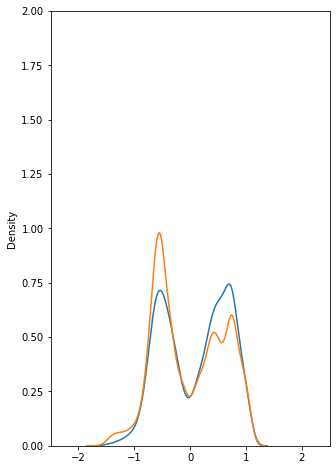

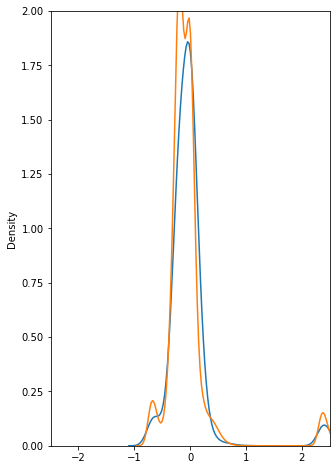

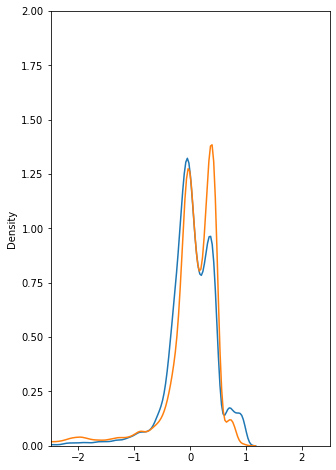

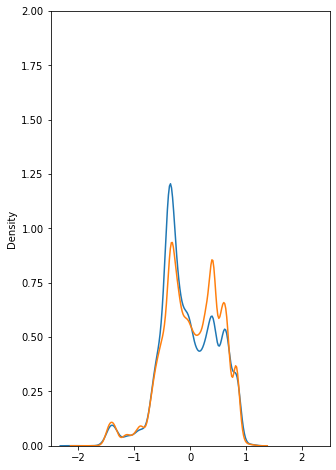

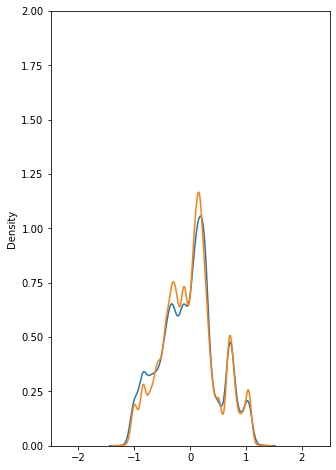

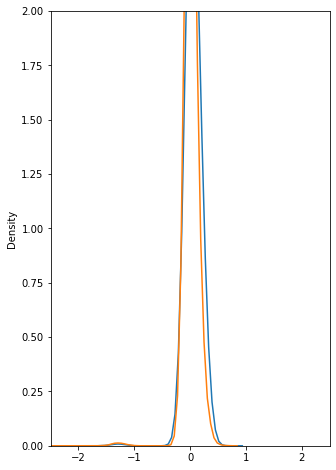

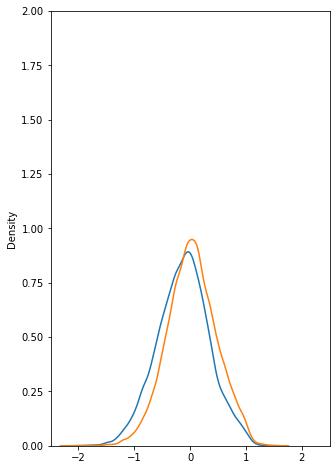

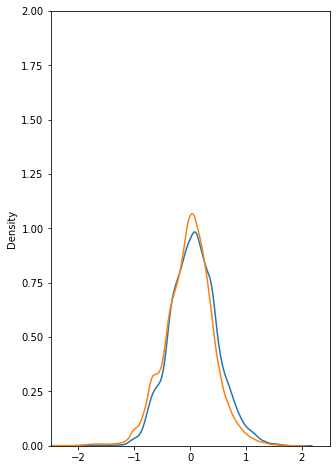

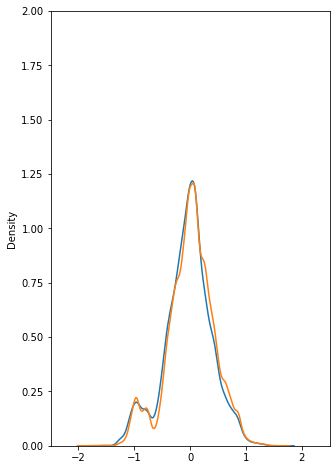

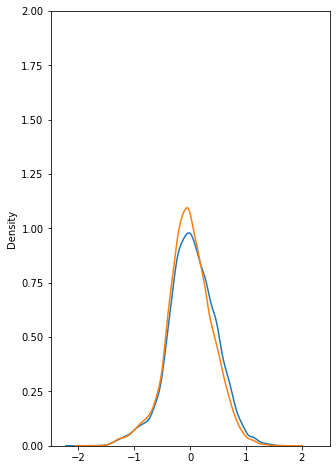

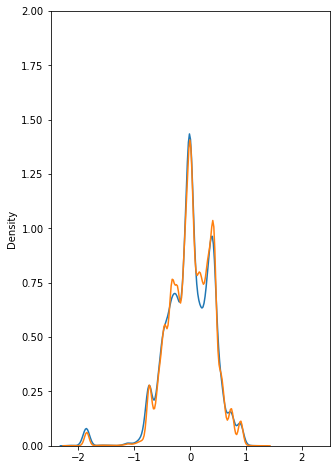

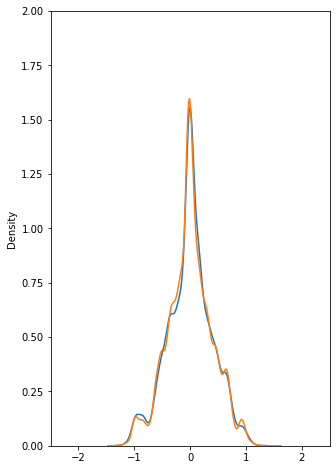

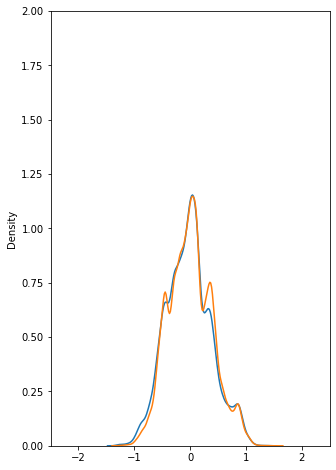

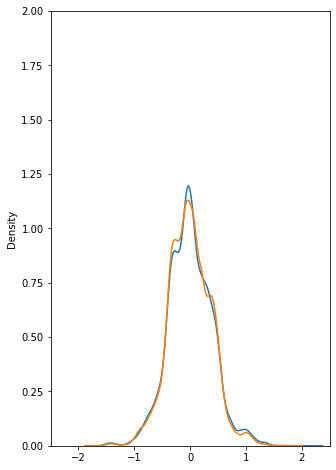

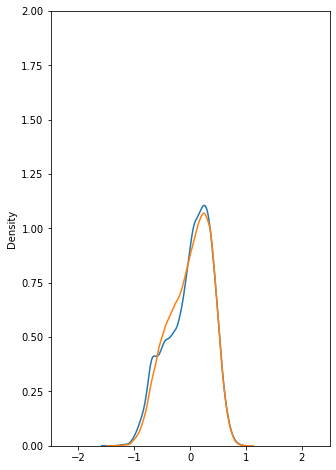

In [110]:

for i in range(0,15):
    plt.figure(figsize=(5,8))
    sns.distplot(coord_sans_nan[data_sans_nan.iloc[:,15]==1,i],hist=False) 
    sns.distplot(coord_sans_nan[data_sans_nan.iloc[:,15]==2,i],hist=False) 
    plt.xlim((-2.5,2.5))
    plt.ylim((0,2))


In [111]:
for j in range(15):
    print( shapiro(coord_sans_nan[data_sans_nan.iloc[:,15]==1,j]), shapiro(coord_sans_nan[data_sans_nan.iloc[:,15]==2,j]) )

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: 

(0.9400959014892578, 0.0) (0.9459327459335327, 0.0)
(0.5237278938293457, 0.0) (0.5481933355331421, 0.0)
(0.8849930167198181, 0.0) (0.7459245920181274, 0.0)
(0.9713298678398132, 0.0) (0.9716548919677734, 0.0)
(0.9846040606498718, 0.0) (0.9869669079780579, 0.0)
(0.15803945064544678, 0.0) (0.17652684450149536, 0.0)
(0.9988471269607544, 1.0145431315802117e-13) (0.9988173842430115, 6.65370770224968e-26)
(0.9965178370475769, 1.4597586321631845e-25) (0.9886163473129272, 0.0)
(0.9854133725166321, 0.0) (0.9852766990661621, 0.0)
(0.9952378869056702, 1.2304616703729529e-29) (0.9942613840103149, 0.0)
(0.9483503103256226, 0.0) (0.9649373292922974, 0.0)
(0.9922227263450623, 1.1599845552113861e-36) (0.9940491914749146, 0.0)
(0.9950872659683228, 4.647572891625749e-30) (0.9949935674667358, 0.0)
(0.9921479821205139, 8.310771606511681e-37) (0.9947836399078369, 0.0)
(0.9675762057304382, 0.0) (0.9772742986679077, 0.0)


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: 

In [112]:
shapiro(coord_sans_nan[data_sans_nan.iloc[:,15]==1,:]), shapiro(coord_sans_nan[data_sans_nan.iloc[:,15]==2,:])

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


((0.9147318601608276, 0.0), (0.953933835029602, 0.0))

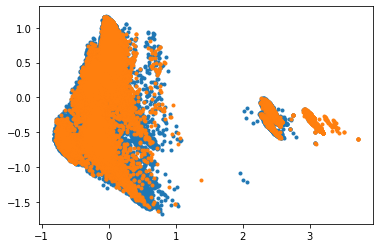

In [113]:
plt.plot(coord_sans_nan[data_sans_nan.iloc[:,15]==2,1], coord_sans_nan[data_sans_nan.iloc[:,15]==2,0],".")
plt.plot(coord_sans_nan[data_sans_nan.iloc[:,15]==1,1], coord_sans_nan[data_sans_nan.iloc[:,15]==1,0],".")

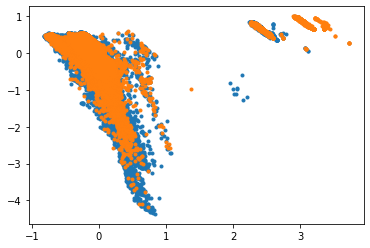

In [114]:
plt.plot(coord_sans_nan[data_sans_nan.iloc[:,15]==2,1], coord_sans_nan[data_sans_nan.iloc[:,15]==2,2],".")
plt.plot(coord_sans_nan[data_sans_nan.iloc[:,15]==1,1], coord_sans_nan[data_sans_nan.iloc[:,15]==1,2],".")

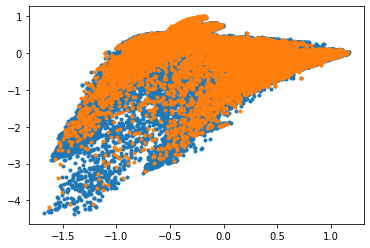

In [115]:
plt.plot(coord_sans_nan[data_sans_nan.iloc[:,15]==2,0], coord_sans_nan[data_sans_nan.iloc[:,15]==2,2],".")
plt.plot(coord_sans_nan[data_sans_nan.iloc[:,15]==1,0], coord_sans_nan[data_sans_nan.iloc[:,15]==1,2],".")

In [116]:
for j in range(15):#23456
    hhh = pd.DataFrame(coord_sans_nan[data_sans_nan.iloc[:,15]==2,j])
    
    q_low = hhh.quantile(0.05)
    q_hi  = hhh.quantile(0.95)
    df_filtered = hhh[(hhh < q_hi) & (hhh > q_low)]

    print(shapiro(df_filtered.dropna()))


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: 

(0.9097604751586914, 0.0)
(0.9828373193740845, 0.0)
(0.9234477281570435, 0.0)
(0.9587929844856262, 0.0)
(0.9823282957077026, 0.0)
(0.9837237596511841, 0.0)
(0.98667973279953, 0.0)


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: 

(0.987086296081543, 0.0)
(0.9912088513374329, 0.0)
(0.9889185428619385, 0.0)
(0.9722937941551208, 0.0)
(0.9869872331619263, 0.0)
(0.9814345836639404, 0.0)
(0.9800136685371399, 0.0)
(0.9598149061203003, 0.0)


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(30439, 1)
(30439, 1)


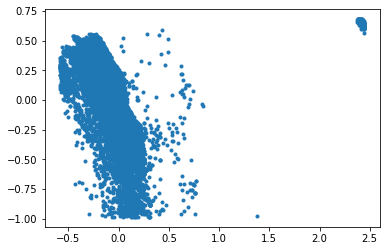

In [117]:
hhh = pd.DataFrame(coord_sans_nan[data_sans_nan.iloc[:,15]==1,1])
q_low = hhh.quantile(0.03)
q_hi  = hhh.quantile(0.95)
df_filtered = hhh[(hhh < q_hi) & (hhh > q_low)]
print(df_filtered.shape)

hhh_2 = pd.DataFrame(coord_sans_nan[data_sans_nan.iloc[:,15]==1,2])
q_low_2 = hhh_2.quantile(0.03)
q_hi_2  = hhh_2.quantile(0.95)
df_filtered_2 = hhh_2[(hhh_2 < q_hi_2) & (hhh_2 > q_low_2)]
print(df_filtered_2.shape)

plt.plot(df_filtered.iloc[:,0], df_filtered_2.iloc[:,0], '.')

In [ ]:

'''
from sklearn.preprocessing import KBinsDiscretizer
# discrétisation des variables continues (les valeurs manquantes doivent être gérées en amont)
 c'est qui est bien avec KBinsDiscretizer est qu'il s'adapte aux éventuelles partitions au
sein d'une variable. En d'autres termes, si la méthode n'arrive pas à partitionner les individus
en k partitions, alors elle esssayera de les partitionner en k-1 partitions, et ainsi de suite, 
jusqu'à atteindre 1 partition (il faut faire attention avec les variables ayant uniquement 
une modalité). Lorsque la méthode rencontre ce cas, elle affichera "UserWaring" pour informer 
l'utilisateur de celui-ci ainsi que les variables concernées. Ceci sera utile plus tard.


method_discre = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile') 
method_discre.fit(data.iloc[:,1:23])
resultat_discre = method_discre.transform(data.iloc[:,1:23])
resultat_discre

# construction du data frame après discrétisation
data2_index = data.iloc[:,0]
df_resultat_discre = pd.DataFrame(resultat_discre,columns=colonnes[1:23], dtype=int )
data_final = pd.concat([data2_index, df_resultat_discre,data["IFI+"]], axis=1 ) #data2_index
data_final

#nombre_mod(data_final)
#nombre_mod(data)

# description des modalités d'une variable
for k in range(1,data_final.shape[1]):
    print(data_final.iloc[:,k].value_counts(dropna=True)); print("="*50)

# description des modalités d'une variable
for k in range(1,data.shape[1]):
    print(data.iloc[:,k].value_counts(dropna=True)); print("="*50)

'''


In [ ]:
###########################################################################################################
#  PIPELINE

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline

In [ ]:
disqual =  Pipeline([("acm", MCA(var_labels = data.columns[1:num_var_max], )),("adl", LinearDiscriminantAnalysis())])

In [ ]:
disqual.fit(data.iloc[:127115, 1:-1].values, data.iloc[:127115, num_var_max] )



In [ ]:
#accès à l'ACM, nombre de composants
print(disqual.named_steps["acm"].n_components_)


In [ ]:
#afficher les valeurs propres
disqual.named_steps["acm"].plot_eigenvalues()


In [ ]:
#coefs. de la fonction score
print(disqual.named_steps["adl"].coef_)


In [ ]:
#prediction
pVote = disqual.predict(vote_test.iloc[:,:-1].values)
print(numpy.unique(pVote,return_counts=True))


In [ ]:
#nombres de facteurs à tester
parametres = [{"acm__n_components":[1,2,5,10,15,20,25,30,32]}]

In [ ]:
1771/4964

0.35676873489121674

In [ ]:
np.unique(data_orig["Sexe"])

array(['04', '05'], dtype=object)

In [ ]:
nombre_mod(data_orig.iloc[:,1:])

,VARIABLE,NOMBRE_MOD,NOMBRE_MOD_SANS_NA
0,IDENT,4,4
1,TypeHabi,38,38
2,GeoFaz_Scl,8,8
3,GeoFaz_cl,31,31
4,ImmoFaz_Scl,9,9
5,ImmoFaz_cl,11,11
6,Anciennete,21,21
7,Logement_prix_m2,21,21
8,Mediane_RFR,2,2
9,Sexe,31,31


In [193]:
data_orig[(data_orig.isnull()).sum(axis=1) == 0].shape[0]

152510